This script visualizes odds ratios (ORs) of cluster-specific comorbidities using UMAP.

Key steps:
1. **Identify cluster-specific diseases**: Filter comorbidities uniquely associated with each cluster.  
   - **Input:** `Data/upset_AD_positive_ICD10.csv`, `Data/upset_AD_negative_ICD10.csv`

2. **Extract ORs**: Retrieve corresponding p-values from the full dataset.  
   - **Input:** `Data/volcano_c{i}_other_ICD10.pickle`

3. **Standardize OR values and prepare data for UMAP**:
   - Normalize OR values using `StandardScaler`.
   - Merge standardized data with cluster information.

4. **Apply UMAP for dimensionality reduction and generate scatter plots**:
   - Reduce high-dimensional OR data into a 2D space for visualization.
   - Assign colors based on cluster-specific ICD-10 codes.
   - Customize point sizes based on OR values.
   - **Output:** `Data/UMAP_OR.csv`

The output provides insights into comorbidity patterns across clusters, allowing for better visualization and interpretation of high-dimensional data.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from math import log10, log2
import pickle

from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
%run -i setupfunc.py

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Load Datasets and Create the cluster-specific ICD10 list

In [4]:
positive = pd.read_csv('Data/upset_AD_positive_ICD10.csv')

In [5]:
# Calculate the number of significant clusters
positive['sum'] = positive[['c0', 'c1', 'c2', 'c3', 'c4']].sum(axis=1)

In [6]:
# Filter to the cluster-specific comorbidities
positive = positive[positive['sum']==1]

In [7]:
negative = pd.read_csv('Data/upset_AD_negative_ICD10.csv')

In [8]:
# Calculate the number of significant clusters
negative['sum'] = negative[['c0', 'c3', 'c4']].sum(axis=1)

In [9]:
# Filter to the cluster-specific comorbidities
negative = negative[negative['sum']==1]

In [10]:
# Merge the positive/negative associations lists
specific_icd = pd.concat([positive, negative], axis=0, ignore_index=True)

In [11]:
# Convert columns c0-c4 to object (string) type
columns_to_convert = ['c0', 'c1', 'c2', 'c3', 'c4']
specific_icd[columns_to_convert] = specific_icd[columns_to_convert].astype(str)

In [12]:
# Create a new column 'significant_col' to store the column names where the value is True
specific_icd["significant_col"] = specific_icd.iloc[:, 1:6].apply(lambda row: [col for col in specific_icd.columns[1:6] if row[col]=='True'], axis=1)

In [13]:
# Extract numbers and convert to a comma-separated string
specific_icd["Specific Cluster"] = specific_icd["significant_col"].apply(lambda x: ", ".join(str(int(col[1:])) for col in x))

In [14]:
specific_icd = specific_icd[['ICD','Specific Cluster']]

In [15]:
# Add "Cluster " prefix to each value in 'Specific Cluster'
specific_icd["Specific Cluster"] = specific_icd["Specific Cluster"].apply(lambda x: f"Cluster {x}")

In [16]:
specific_icd.head(3)

,ICD,Specific Cluster
0,G31.01,Cluster 0
1,Z00.6,Cluster 0
2,A08.4,Cluster 1


# Load Datasets of ORs in each cluster

In [17]:
# Prepare a dictionary to store file names and data
data_dict = {}

# Loop through files from c0 to c4, read them, and add a 'Cluster' column
for i in range(5):
    file_name = f'Data/volcano_c{i}_other_ICD10.pickle'
    
    with open(file_name, 'rb') as file:
        data = pickle.load(file)  # Load the pickle file
        
        # Convert the 'ICD10' data into a DataFrame
        df = pd.DataFrame(data['ICD10'])  
        
        # Add a 'Cluster' column with the corresponding cluster number
        df['Cluster'] = i  

        # Store the DataFrame in the dictionary
        data_dict[f'c{i}'] = df  

In [18]:
# Concatenate all DataFrames stored in the dictionary vertically
combined_df = pd.concat(data_dict.values(), ignore_index=False)

In [19]:
all_data = combined_df[['-log_pvalue','pvalue','OddsRatio','Cluster']]

In [20]:
all_data = all_data.reset_index()

In [21]:
all_data['ICD10_chape'] = all_data['ICD10'].apply(lambda x: ICD10_code_to_chapter(str(x)[0:3])) # Get ICD10 Chapte

In [22]:
all_data['ICD10_chape_name'] = all_data['ICD10_chape'].apply(lambda x: ICDchapter_to_name(x))

In [23]:
# Remove records containing 'IMO' in the 'ICD10' column
all_data = all_data[~all_data['ICD10'].str.contains('IMO', na=False)]

In [24]:
all_data.head(3)

,ICD10,-log_pvalue,pvalue,OddsRatio,Cluster,ICD10_chape,ICD10_chape_name
0,I10,311.141798,7.214422e-312,0.088273,0,I00–I99,Diseases of Circulatory System
1,F02.80,17.283751,5.202943e-18,0.668747,0,F00–F99,Mental and Behavioural Disorders
2,F03.90,241.876775,1.328083e-242,0.208897,0,F00–F99,Mental and Behavioural Disorders


In [25]:
# Filter to the cluster-specific comorbidities
ORs = all_data.merge(specific_icd, left_on="ICD10", right_on="ICD", how="inner")

In [26]:
# Create a pivot table
pivot_df = ORs.pivot_table(index='ICD10', columns='Cluster', values='OddsRatio')

In [27]:
# Change the columns name
pivot_df.columns = [f'Cluster {int(col)}' for col in pivot_df.columns]

In [28]:
# Reset Index
pivot_df = pivot_df.reset_index()

In [29]:
pivot_df['ICD_chape'] = pivot_df['ICD10'].apply(lambda x: ICD10_code_to_chapter(str(x)[0:3])) # Get ICD10 Chapte

In [30]:
pivot_df = pivot_df.merge(specific_icd, left_on="ICD10", right_on="ICD", how="inner")

In [31]:
# Assign OR value based on 'Specific Cluster'
pivot_df["maxOR"] = pivot_df.apply(lambda row: row[f"{row['Specific Cluster']}"], axis=1)

In [32]:
pivot_df.head(3)

,ICD10,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,ICD_chape,ICD,Specific Cluster,maxOR
0,A04.7,0.044131,6.170000,2.24225,14.035980,0.000000,A00–B99,A04.7,Cluster 3,14.035980
1,A04.72,0.166408,1.585298,3.10851,2.458968,2.404492,A00–B99,A04.72,Cluster 2,3.108510
2,A04.72,0.166408,1.585298,3.10851,2.458968,2.404492,A00–B99,A04.72,Cluster 0,0.166408


# Standardization for UMAP

In [33]:
# Standardize the OR values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df.iloc[:, 1:6])  # Standardize columns corresponding to OR values

# Convert the result into a DataFrame
standardized_df = pd.DataFrame(scaled_data, columns=pivot_df.columns[1:6])


In [34]:
umap_df = pd.concat([pivot_df[['ICD10','Specific Cluster','maxOR']],standardized_df], axis=1)

# UMAP

In [35]:
X = umap_df.iloc[:, 3:]

In [36]:
X.head(3)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,-0.278684,-0.350059,-0.504982,2.568678,-0.916610
1,0.161803,-0.541760,-0.299092,-0.142514,1.197512
2,0.161803,-0.541760,-0.299092,-0.142514,1.197512


In [37]:
umap_reducer = umap.UMAP(n_neighbors=10, min_dist=0.5, random_state=42)
reduced_data = umap_reducer.fit_transform(X)

/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


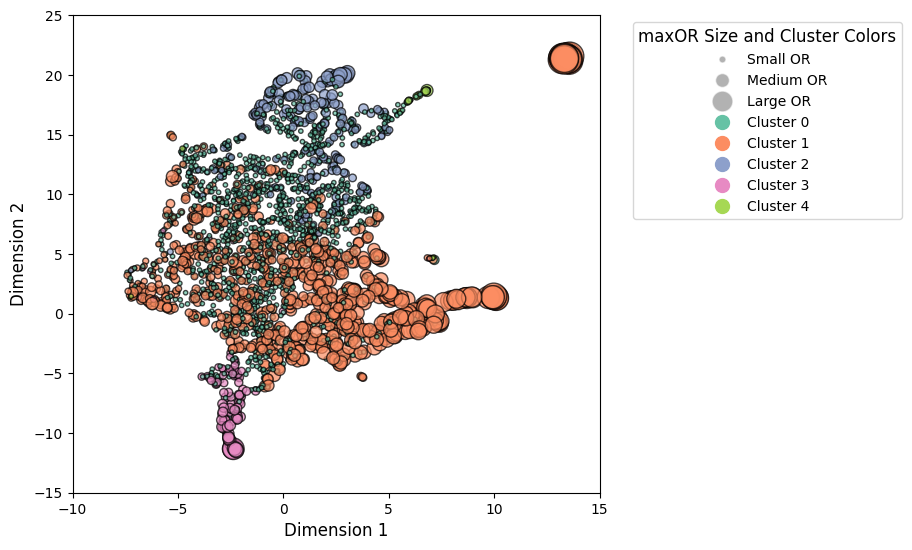

In [38]:
# Define color mapping for each cluster
category_color_mapping = {
    'Cluster 0': '#66c2a5',  # Light green
    'Cluster 1': '#fc8d62',  # Dark red
    'Cluster 2': '#8da0cb',  # Blue - high visibility
    'Cluster 3': '#e78ac3',  # Purple - vibrant yet subtle
    'Cluster 4': '#a6d854',  # Yellow - bright and easily distinguishable
}

# Randomize the plotting order
np.random.seed(42)
reordered_indices = np.arange(reduced_data.shape[0])
np.random.shuffle(reordered_indices)

# Assign colors based on the cluster of each ICD-10 code
colors = [category_color_mapping.get(icd, '#000000') for icd in umap_df["Specific Cluster"]]

# Log transformation + smoothing + scaling
scaled_dot_sizes = (np.log1p(umap_df["maxOR"].values) ** 3.5)  # Apply log transformation and enhance differences
scaled_dot_sizes = (scaled_dot_sizes - scaled_dot_sizes.min()) / (scaled_dot_sizes.max() - scaled_dot_sizes.min()) * 400
scaled_dot_sizes += 10  # Ensure a minimum dot size


# Create the scatter plot
plt.figure(figsize=(6.8, 6.2))
scatter = plt.scatter(
    reduced_data[reordered_indices, 0],
    reduced_data[reordered_indices, 1],
    c=np.array(colors)[reordered_indices],  # Assign color for each ICD-10 code
    s=scaled_dot_sizes[reordered_indices],  # Set dot size based on maxOR
    alpha=0.7,
    edgecolor='k'  # Set black border for better visibility
)

# Define legend elements for dot sizes (OR scale)
size_legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Small OR', markersize=5, markerfacecolor='gray', alpha=0.6),
    plt.Line2D([0], [0], marker='o', color='w', label='Medium OR', markersize=10, markerfacecolor='gray', alpha=0.6),
    plt.Line2D([0], [0], marker='o', color='w', label='Large OR', markersize=15, markerfacecolor='gray', alpha=0.6),
]

# Define legend elements for cluster colors
color_legend_elements = [
    plt.Line2D([0], [0], marker='o', color=color, label=cluster, markersize=10, linestyle='None')
    for cluster, color in category_color_mapping.items()
]

# Add legend for dot sizes and cluster colors
plt.legend(
    handles=size_legend_elements + color_legend_elements,
    title="maxOR Size and Cluster Colors",
    fontsize=10,
    loc='upper left',  # Position the legend at the upper left
    bbox_to_anchor=(1.05, 1),  # Place the legend outside the plot (top right)
    title_fontsize=12
)

# Set axis labels
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)

# Define tick interval for both axes
tick_interval = 5  

# Determine axis limits
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

# Generate evenly spaced tick positions
x_ticks = np.arange(np.floor(x_min / tick_interval) * tick_interval, np.ceil(x_max / tick_interval) * tick_interval + tick_interval, tick_interval)
y_ticks = np.arange(np.floor(y_min / tick_interval) * tick_interval, np.ceil(y_max / tick_interval) * tick_interval + tick_interval, tick_interval)

# Set uniform tick intervals on both axes
plt.xticks(x_ticks)
plt.yticks(y_ticks)

# Save and display the plot
plt.savefig("Figures/UMAP_ORs.pdf", dpi=600, format="pdf", bbox_inches="tight")
plt.show()

In [39]:
reduced_df = pd.DataFrame(reduced_data, columns=['X','Y'])

In [40]:
df = pd.concat([pivot_df[['ICD10','ICD_chape','Specific Cluster','maxOR']],reduced_df], axis=1)

In [41]:
df.to_csv('Data/UMAP_OR.csv', index=False)